In [1]:
import os
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, Aer, IBMQ
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
import qiskit.quantum_info as qi

from pulse_experiment_utils import *

In [2]:
#phi_values = np.linspace(0., np.pi / 2., 40)
#phi_values = np.array([0.1, 0.44, np.pi / 2.])
phi_values = np.concatenate((np.linspace(0., np.pi / 6., 20, endpoint=False), np.linspace(np.pi / 6., np.pi * 14. / 54., 6, endpoint=False), np.linspace(np.pi * 14. / 54., np.pi, 9)))
print(phi_values)
experiments = ['cx', 'pe', 'li']

[0.         0.02617994 0.05235988 0.07853982 0.10471976 0.13089969
 0.15707963 0.18325957 0.20943951 0.23561945 0.26179939 0.28797933
 0.31415927 0.3403392  0.36651914 0.39269908 0.41887902 0.44505896
 0.4712389  0.49741884 0.52359878 0.57208014 0.62056151 0.66904288
 0.71752425 0.76600562 0.81448698 1.10537519 1.3962634  1.68715161
 1.97803982 2.26892803 2.55981624 2.85070444 3.14159265]


## Write the results in an HDF5 file if one does not exist yet

In [3]:
results_file_name = 'rzz_circuits_results_oct01_3.h5'
job_id_file_name = 'job_ids_sep21'
mitigation_job_id_file_name = 'job_ids_sep21_mitigation.txt'

if not os.path.exists(results_file_name):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='q-comp-training')
    backend = provider.get_backend('ibm_kawasaki')
    
    with h5py.File(results_file_name, 'w') as out:
        for exp in experiments:
            group = out.create_group(exp)
            
            with open('{}_{}.txt'.format(job_id_file_name, exp)) as source:
                lines = source.read().strip().split('\n')

                for iphi, line in enumerate(lines):
                    _, _, job_id = line.split()

                    print('{} {}'.format(exp, iphi))


                    try:
                        job_result = job.result()
                    except:
                        continue

                    for result in job_result.results:
                        try:
                            dataset = group[result.header.name]
                        except KeyError:
                            dataset = group.create_dataset(result.header.name, (len(lines), 4), dtype='i')

                        counts = result.data.counts
                        dataset[iphi] = np.array([counts.get(hex(idx), 0) for idx in range(4)])

        group = out.create_group('readout_error')
        
        circuits_per_target = 16
        shots = 8192

        dataset = group.create_dataset('shots', (1,), dtype='i')
        dataset[0] = circuits_per_target * shots
        
        dataset = group.create_dataset('counts', (4, 4), dtype='i')
        
        with open(mitigation_job_id_file_name) as source:
            job_id = source.readline().strip()
            job = backend.retrieve_job(job_id)
            job_result = job.result()
            counts = job_result.get_counts()
            
            for icol in range(4):
                for icirc in range(icol * circuits_per_target, (icol + 1) * circuits_per_target):
                    for irow in range(4):
                        dataset[irow, icol] += counts[icirc].get('{:02b}'.format(irow), 0)

## Raw fidelity values

In [4]:
fidelities = dict()

with h5py.File(results_file_name, 'r') as source:
    for exp in experiments:
        fidelities[exp] = np.empty_like(phi_values)
        
        data = [dict() for _ in range(phi_values.shape[0])]
    
        for key, rawdata in source[exp].items():
            # for h5 files with fidelity values
            if not key.startswith('('):
                continue

            for iphi in range(phi_values.shape[0]):
                data[iphi][key] = rawdata[iphi]

        for iphi in range(phi_values.shape[0]):
            channel = run_process_tomography(data[iphi])

            target_circuit = QuantumCircuit(2)
            target_circuit.rzz(phi_values[iphi], 0, 1)
            target = qi.Operator(target_circuit)

            fidelities[exp][iphi] = qi.process_fidelity(channel, target=target, require_tp=False)

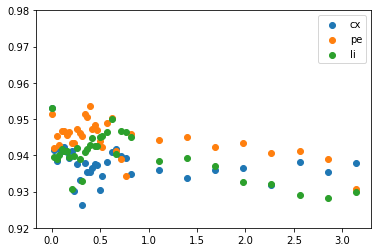

In [5]:
with h5py.File(results_file_name, 'r') as source:
    for exp in experiments:
        plt.scatter(phi_values, fidelities[exp], label=exp)
plt.ylim(0.92, 0.98)
plt.legend()

## Apply a readout error mitigation

In [6]:
data = dict()

with h5py.File(results_file_name, 'r') as source:
    error_matrix = np.empty((4, 4), dtype='f8')
    error_matrix[:] = source['readout_error']['counts'] / source['readout_error']['shots'][0]
    
    for exp in experiments:
        data[exp] = [dict() for _ in range(phi_values.shape[0])]
        
        for key, rawdata in source[exp].items():
            # for h5 files with fidelity values
            if not key.startswith('('):
                continue
                
            for iphi in range(phi_values.shape[0]):
                data[exp][iphi][key] = readout_error_mitigation(rawdata[iphi], error_matrix)

## Error-mitigated fidelity values

In [7]:
fidelities = dict()

for exp in experiments:
    fidelities[exp] = np.empty_like(phi_values)

    for iphi in range(phi_values.shape[0]):
        channel = run_process_tomography(data[exp][iphi])

        target_circuit = QuantumCircuit(2)
        target_circuit.rzz(phi_values[iphi], 0, 1)
        target = qi.Operator(target_circuit)

        fidelities[exp][iphi] = qi.process_fidelity(channel, target=target, require_tp=False)

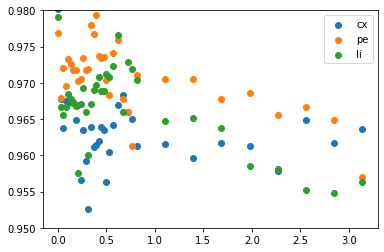

In [19]:
for exp in experiments:
    plt.scatter(phi_values, fidelities[exp], label=exp)
plt.ylim(0.95, 0.98)
plt.legend()

In [9]:
def scan_delta_phi(counts, phi_value):
    channel = run_process_tomography(counts)

    best_solution = (None, 0.)
    for dphi in np.linspace(-0.5, 0.5, 200):
        target_circuit = QuantumCircuit(2)
        target_circuit.rzz(phi_value + dphi, 0, 1)
        target = qi.Operator(target_circuit)

        fidelity = qi.process_fidelity(channel, target=target, require_tp=False)
        
        if fidelity > best_solution[1]:
            best_solution = (dphi, fidelity)
            
    return best_solution

In [10]:
deviations = dict()
max_fidelities = dict()
for exp in experiments:
    deviations[exp] = np.empty_like(phi_values)
    max_fidelities[exp] = np.empty_like(phi_values)
    
    for iphi, phi_value in enumerate(phi_values):
        dphi, f = scan_delta_phi(data[exp][iphi], phi_value)
        deviations[exp][iphi] = dphi
        max_fidelities[exp][iphi] = f

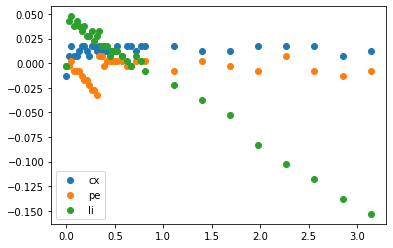

In [11]:
for exp in experiments:
    plt.scatter(phi_values, deviations[exp], label=exp)
plt.legend()

### There appears to be a linear trend in the linearized scheme; calibrate it out

In [14]:
def line(x, slope, intercept):
    return x * slope + intercept

popt, _ = scipy.optimize.curve_fit(line, phi_values, deviations['li'], p0=[-0.1, 0.06])
print(popt)

[-0.06197974  0.04280589]


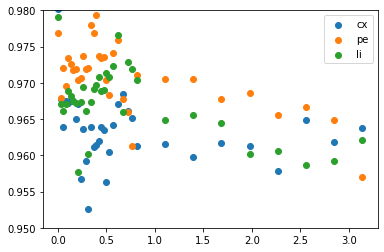

In [20]:
for exp in experiments:
    plt.scatter(phi_values, max_fidelities[exp], label=exp)
plt.ylim(0.95, 0.98)
plt.legend()

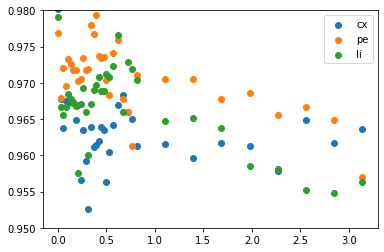

In [21]:
for exp in experiments:
    plt.scatter(phi_values, fidelities[exp], label=exp)
plt.ylim(0.95, 0.98)
plt.legend()

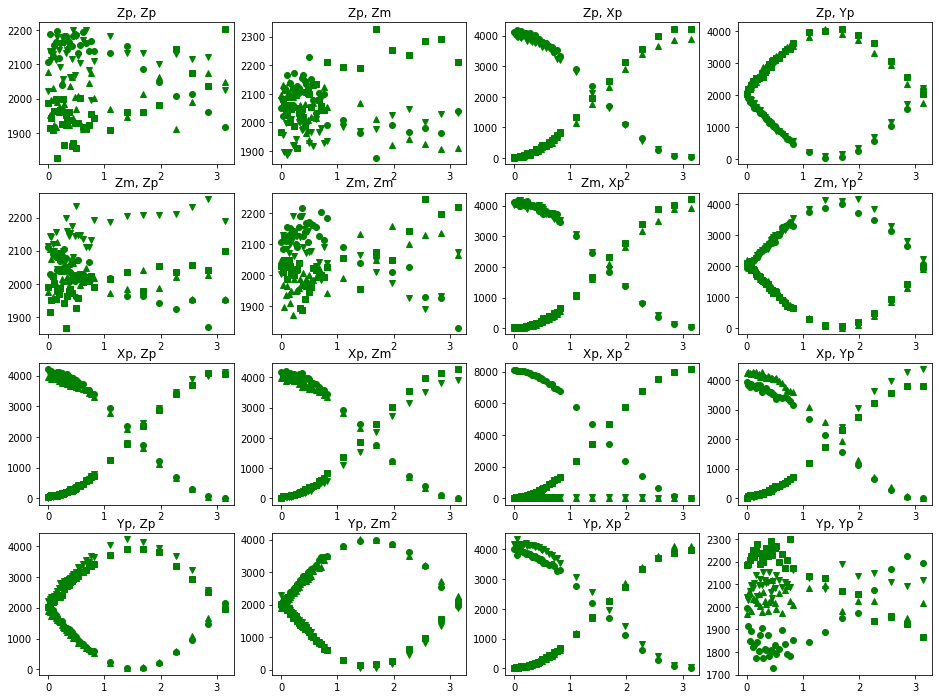

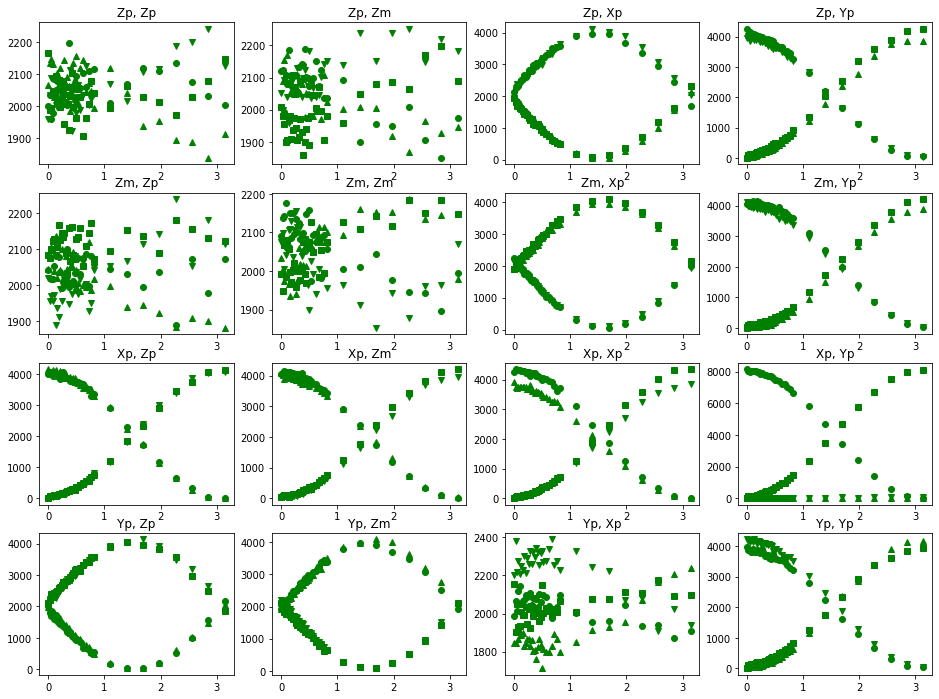

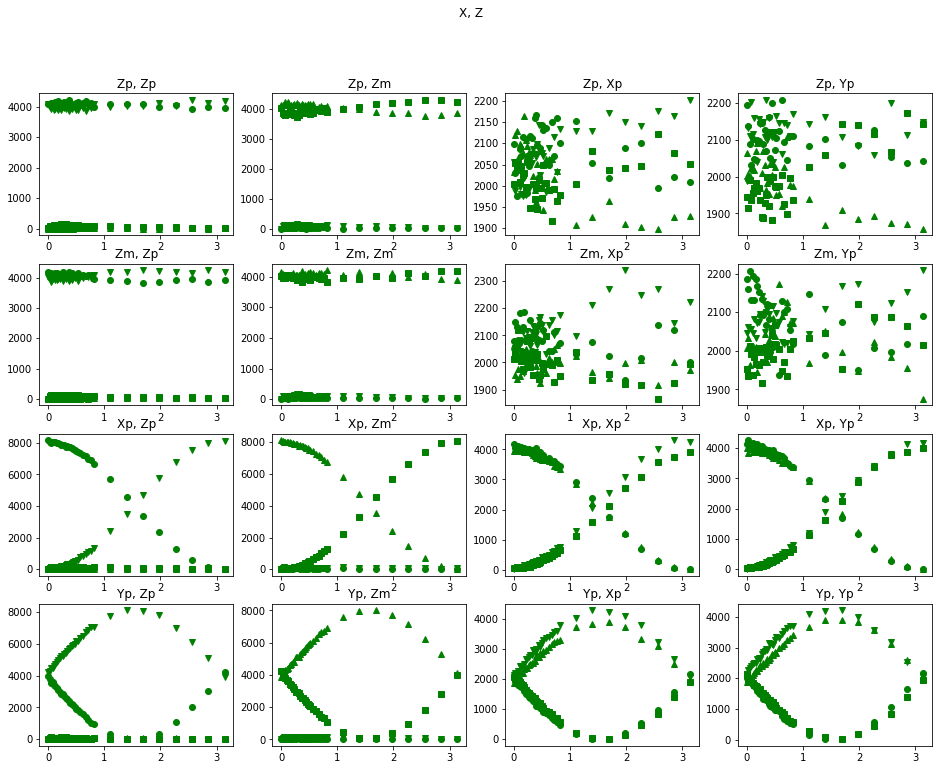

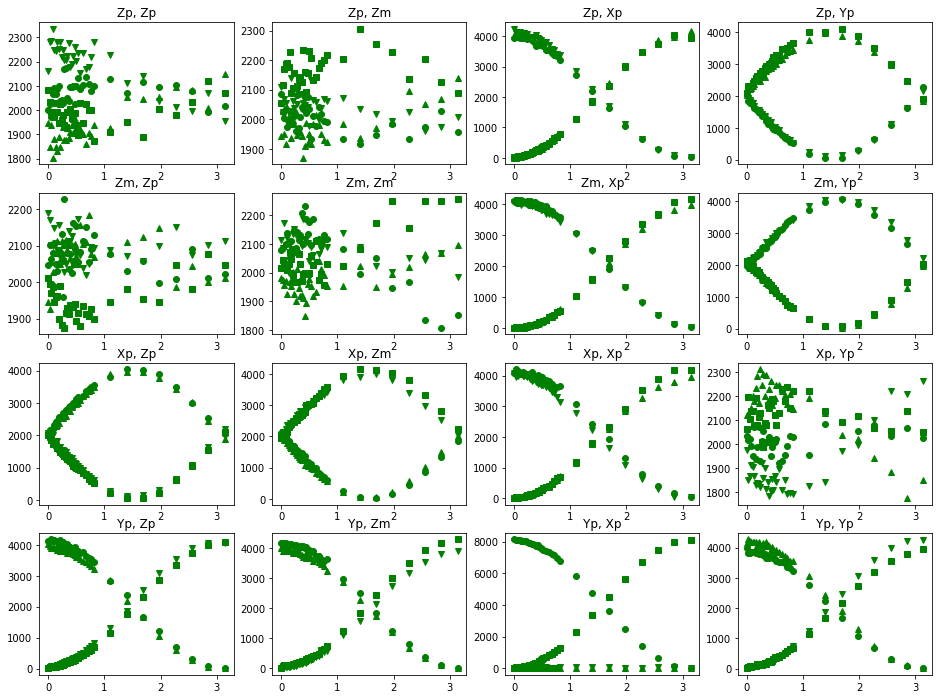

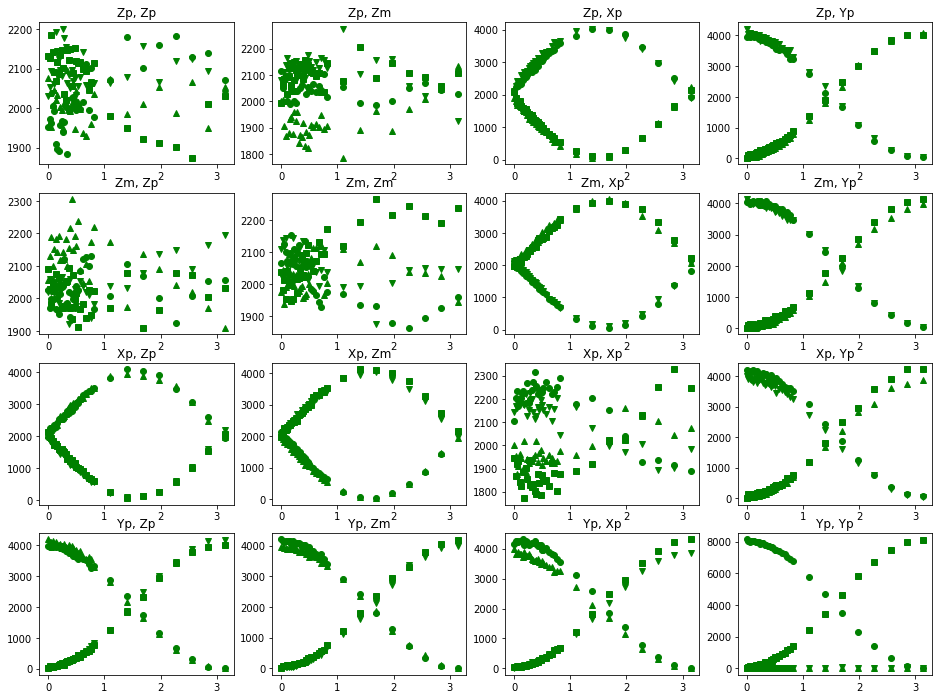

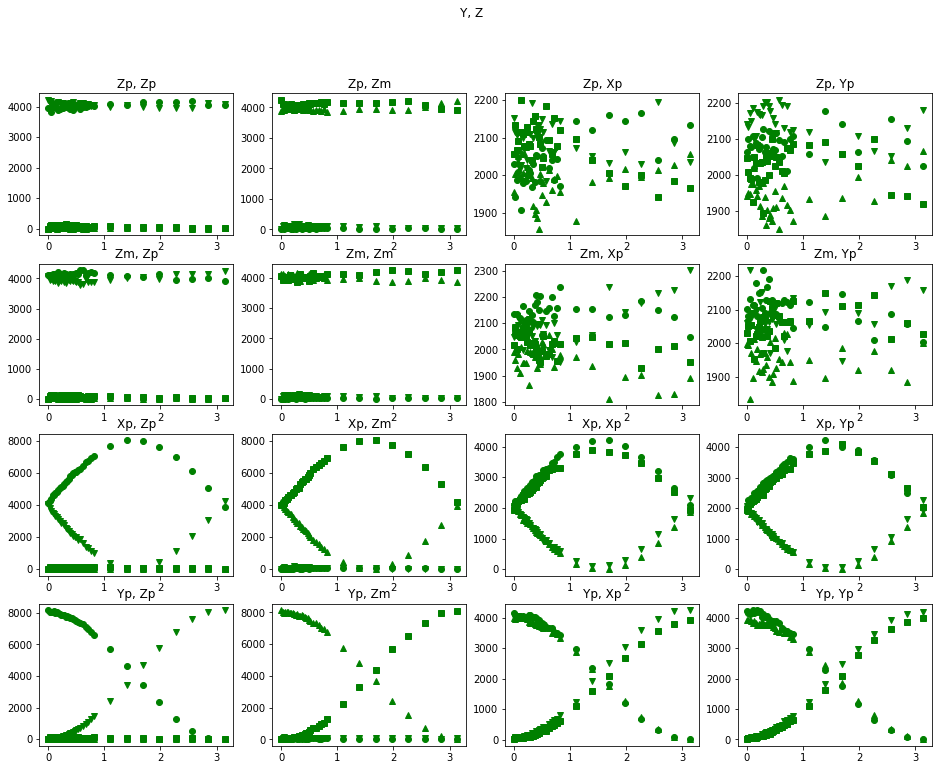

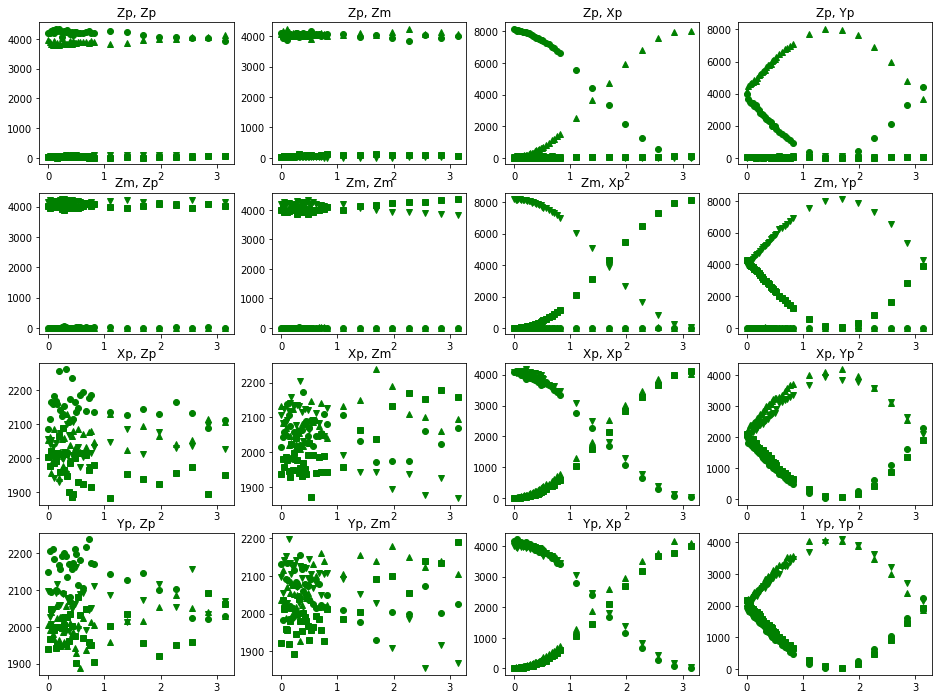

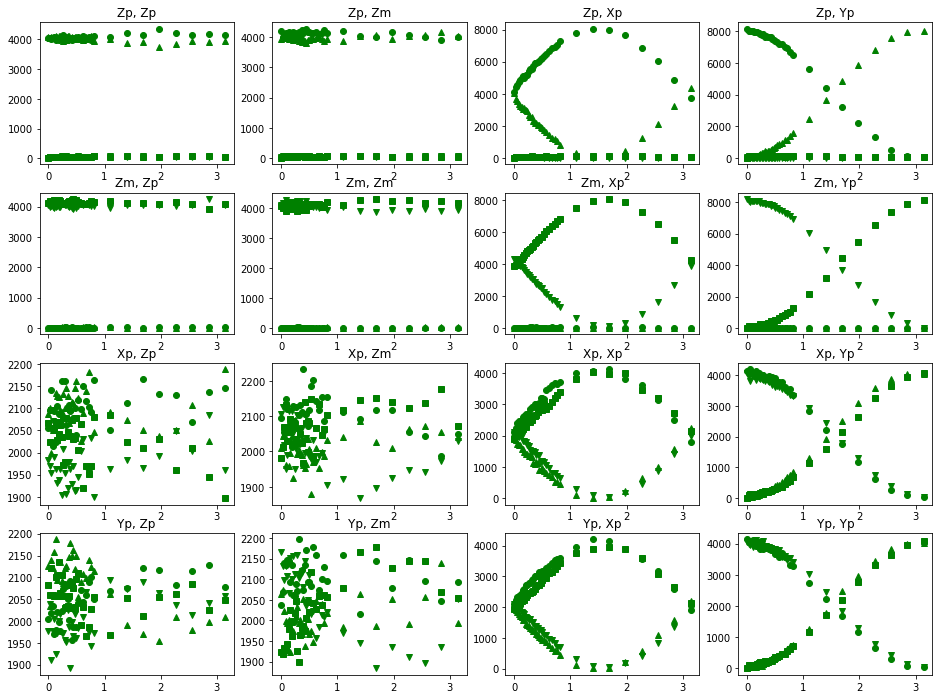

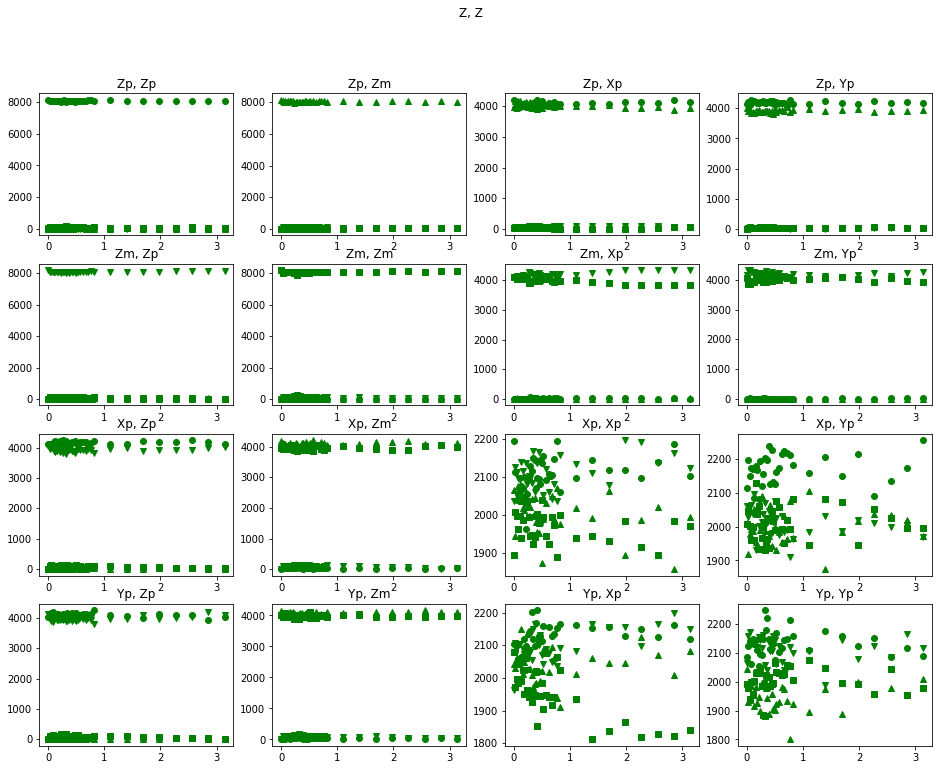

In [16]:
#colors = ['b', 'r', 'g']
colors = ['g']
shapes = ['o', 'v']
# with h5py.File(results_file_name, 'r') as source:
#     for cmmt in ['X', 'Y', 'Z']:
#         for tmmt in ['X', 'Y', 'Z']:
#             fig, axs = plt.subplots(4, 4, figsize=(16, 12))

#             for ic, cprep in enumerate(['Zp', 'Zm', 'Xp', 'Yp']):
#                 for it, tprep in enumerate(['Zp', 'Zm', 'Xp', 'Yp']):
#                     name = "(('{}', '{}'), ('{}', '{}'))".format(cprep, tprep, cmmt, tmmt)
#                     for exp, color in zip(['cx', 'pe', 'li'], colors):
#                         axs[ic, it].plot(phi_values, source[exp][name][:, 0], color + 'o', linewidth=0, label='{} 00'.format(exp))
#                         axs[ic, it].plot(phi_values, source[exp][name][:, 1], color + 'v', linewidth=0, label='{} 01'.format(exp))
#                         axs[ic, it].plot(phi_values, source[exp][name][:, 2], color + '^', linewidth=0, label='{} 10'.format(exp))
#                         axs[ic, it].plot(phi_values, source[exp][name][:, 3], color + 's', linewidth=0, label='{} 11'.format(exp))
                        
#                     axs[ic, it].set_title('{}, {}'.format(cprep, tprep))

#         fig.suptitle('{}, {}'.format(cmmt, tmmt))

for cmmt in ['X', 'Y', 'Z']:
    for tmmt in ['X', 'Y', 'Z']:
        fig, axs = plt.subplots(4, 4, figsize=(16, 12))

        for ic, cprep in enumerate(['Zp', 'Zm', 'Xp', 'Yp']):
            for it, tprep in enumerate(['Zp', 'Zm', 'Xp', 'Yp']):
                key = "(('{}', '{}'), ('{}', '{}'))".format(cprep, tprep, cmmt, tmmt)
                for exp, color in zip(experiments, colors):
                    plot_data = np.empty((phi_values.shape[0], 4))
                    for iphi in range(phi_values.shape[0]):
                        plot_data[iphi] = data[exp][iphi][key]
                        
                    axs[ic, it].plot(phi_values, plot_data[:, 0], color + 'o', linewidth=0, label='{} 00'.format(exp))
                    axs[ic, it].plot(phi_values, plot_data[:, 1], color + 'v', linewidth=0, label='{} 01'.format(exp))
                    axs[ic, it].plot(phi_values, plot_data[:, 2], color + '^', linewidth=0, label='{} 10'.format(exp))
                    axs[ic, it].plot(phi_values, plot_data[:, 3], color + 's', linewidth=0, label='{} 11'.format(exp))

                axs[ic, it].set_title('{}, {}'.format(cprep, tprep))

    fig.suptitle('{}, {}'.format(cmmt, tmmt))

In [17]:
np.linspace(np.pi / 6., np.pi, 10)

array([0.52359878, 0.81448698, 1.10537519, 1.3962634 , 1.68715161,
       1.97803982, 2.26892803, 2.55981624, 2.85070444, 3.14159265])

In [18]:
np.pi * (1./6. + 5./54.)

0.8144869842640204